In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

<h1 style="color:blue; font-weight:bold;"> Data Cleaning </h1>

Arbitrarily, I choose to remove the columns 'availability' and 'society' which I don't find relevant for our prediction problem.

In [4]:
df1 = df.drop(['availability', 'society'], axis = 'columns')
df1.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [5]:
df1.isna().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

Since the dataset is big enough, I choose to get rid of the NaN values.

In [6]:
df2 = df1.dropna()
df2.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

Now, we will study some columns which may contain wrong encoded features.

In [7]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

Here we can notice that the bedroom counting is not homogeneous. For instance, a house with 3 bedrooms can be written '3 BHK' or '3 Bedroom'. We need to fix this in order to allow the predictions.

In [8]:
def extract_nb_bedrooms(size : str) -> int :
    return int(size.split(' ')[0])

In [9]:
df3 = df2.copy()
df3['bedroom_formated'] = df2['size'].apply(extract_nb_bedrooms)

In [10]:
df3 = df3.drop('size', axis = 'columns')

In [11]:
df3['total_sqft']

0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13314    1715
13315    3453
13317    1141
13318    4689
13319     550
Name: total_sqft, Length: 12710, dtype: object

Some houses are listed with a range for the surface area instead of a unique value or with a different unit. We will replace these ranges with the mean value, and convert in the correct unit using Regex.
At this stage, we choose to remove certain conversion values that seem particularly low/high, in order to discard potential calculation errors. The interval we'll keep is [50, 20000] sqft.

In [12]:
import re

In [13]:
df3['total_sqft'] = df3['total_sqft'].apply(str)
def format_surf_area(area : str) -> int:
    if '-' in area:
        min = float(area.split(' ')[0])
        max = float(area.split(' ')[-1])
        return (min + max)/2
    else:
        try:
            return float(area)
        except:
            # return None
            decomp = re.match(r'([\d.]+)\s*(.*)', area)
            value = float(decomp.group(1))
            unity = decomp.group(2)         
            if unity=='Sq. Meter':
                conversion = value*10.764 # 1 m² = 10.764 sqft
            elif unity=='Perch':
                conversion = value*272.3 # 1 perch = 272.3 sqft
            elif unity=='Acres':
                conversion = value*43560 # 1 Acre = 43560 sqft
            elif unity=='Guntha':
                conversion = value*1089 # 1 Gunta = 1089 sqft
            elif unity=='Sq. Yards':
                conversion = value*9 # 1 Yard = 9 sqft
            elif unity=='Cents':
                conversion = value*431 # 1 Cent = 431 sqft
            elif unity=='Grounds':
                conversion = value*2400 # 1 Cent = 2400 sqft
        if conversion < 50 or conversion > 20000:
            return None
        else:
            return conversion

In [14]:
df4 = df3.copy()
df4['surf_formated'] = df3['total_sqft'].apply(format_surf_area)

In [15]:
df4 = df4.dropna() # To remove the outliers with surface not included in [50, 20000] sqft.
df4 = df4.drop('total_sqft', axis = 'columns')
df4.head()

,area_type,location,bath,balcony,price,bedroom_formated,surf_formated
0,Super built-up Area,Electronic City Phase II,2.0,1.0,39.07,2,1056.0
1,Plot Area,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Uttarahalli,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Kothanur,2.0,1.0,51.00,2,1200.0


In [16]:
df4.isna().sum()

area_type           0
location            0
bath                0
balcony             0
price               0
bedroom_formated    0
surf_formated       0
dtype: int64

At this moment, the values in this dataframe must be well-formated. We still have to One-Hot encode the categorical features.

In [17]:
oh_features = pd.get_dummies(df4[['area_type', 'location']])

In [18]:
oh_features.shape

(12697, 1264)

We encounter an issue here : there are too much different locations, OH encoding would create 1260+ features. To tackle this issue, we will group the locations with less than 50 occurrences in a category 'Other'.

In [19]:
df_tmp = df4.groupby('location')['location'].agg('count')

In [20]:
list_loc_ok = df_tmp[df_tmp>50].sort_values(ascending=False)

In [21]:
def format_location(loc : str) -> str:
    if loc in list_loc_ok:
        return loc
    else:
        return 'Other'

In [22]:
df5 = df4.copy()
df5['loc_formated'] = df4['location'].apply(format_location)
df5 = df5.drop('location', axis = 'columns')

In [23]:
df5.groupby('loc_formated')['loc_formated'].agg('count')

loc_formated
7th Phase JP Nagar           147
8th Phase JP Nagar            56
Akshaya Nagar                 58
Banashankari                  74
Bannerghatta Road            144
Begur Road                    83
Bellandur                     91
Bisuvanahalli                 51
Budigere                      54
Chandapura                    98
Electronic City              300
Electronic City Phase II     130
Electronics City Phase 1      86
Haralur Road                 135
Harlur                        76
Hebbal                       173
Hennur                        51
Hennur Road                  142
Hoodi                         86
Hormavu                       71
Hosa Road                     72
JP Nagar                      64
Jakkur                        67
KR Puram                      85
Kaggadasapura                 61
Kanakpura Road               259
Kasavanhalli                  77
Kengeri                       71
Koramangala                   69
Kothanur                      

In [24]:
df5.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2308
Carpet  Area              82
Plot  Area              1826
Super built-up  Area    8481
Name: area_type, dtype: int64

No need to do the same operation with the 'area_type' feature since there are only 4 different values.

Now, we have 50 different locations. We will keep the columns 'loc_formated' and 'area_type' for the moment because it is more convenient for outliers removing.

In [25]:
df6 = df5.copy()

The dataset is well-formated. We still have to remove the outliers in order to improve the future model we will use. To do so, I will introduce two temporary features : price per sqft, number of sqft per bedroom. We will get rid of the rows with a Z-score between -1 and 1 for the price_per_sqft, and discard the rows with an area_per_bedroom lower than 300 sqft. 


A final filter will be applied on the bath number. Arbitrarily, we choose to discard the rows with more bathrooms than bedrooms.

In [26]:
df6['price_per_sqft'] = df6.price / df6.surf_formated
df6['area_per_bedroom'] = df6.surf_formated / df6.bedroom_formated

In [27]:
df6.shape

(12697, 9)

In [28]:
from scipy import stats

In [29]:
df_outliers_removing = df6.copy()
df_outliers_removing = df_outliers_removing[~(df_outliers_removing['area_per_bedroom']<300)]

In [30]:
df_outliers_removing.shape

(12038, 9)

In [31]:
df_outliers_removing['zscore_price_per_sqft'] = df_outliers_removing.groupby('loc_formated')['price_per_sqft'].transform(lambda x: stats.zscore(x))

In [32]:
df_outliers_removing.head()

,area_type,bath,balcony,price,bedroom_formated,surf_formated,loc_formated,price_per_sqft,area_per_bedroom,zscore_price_per_sqft
0,Super built-up Area,2.0,1.0,39.07,2,1056.0,Electronic City Phase II,0.036998,528.0,-0.057460
1,Plot Area,5.0,3.0,120.00,4,2600.0,Other,0.046154,650.0,-0.416340
2,Built-up Area,2.0,3.0,62.00,3,1440.0,Uttarahalli,0.043056,480.0,0.010446
3,Super built-up Area,3.0,1.0,95.00,3,1521.0,Other,0.062459,507.0,-0.070597
4,Super built-up Area,2.0,1.0,51.00,2,1200.0,Kothanur,0.042500,600.0,-0.725487


In [33]:
df_outliers_removing = df_outliers_removing[abs(df_outliers_removing['zscore_price_per_sqft'])<1] # Outliers price per square ft
print(df_outliers_removing.shape)

(10373, 10)


In [34]:
df_outliers_removing = df_outliers_removing[df_outliers_removing['bath']<=df_outliers_removing['bedroom_formated']] # Outliers bath numbers
print(df_outliers_removing.shape)

(9858, 10)


In [35]:
dummies_var = pd.get_dummies(df_outliers_removing[['area_type', 'loc_formated']], drop_first = True)

In [36]:
df7 = pd.concat([df_outliers_removing.drop(['area_type', 'loc_formated', 'price_per_sqft', 'area_per_bedroom', 'zscore_price_per_sqft'], axis = 'columns'), dummies_var], axis = 'columns')

In [37]:
df7.shape

(9858, 57)

In [38]:
print(f'After removing the outliers, {df7.shape[0]} houses remain, out of the original {df.shape[0]}.')

After removing the outliers, 9858 houses remain, out of the original 13320.


<h1 style="color:blue; font-weight:bold;"> Data Visualization </h1>

In [39]:
list_columns_to_visualize = ['bath', 'balcony', 'price', 'bedroom_formated', 'surf_formated']

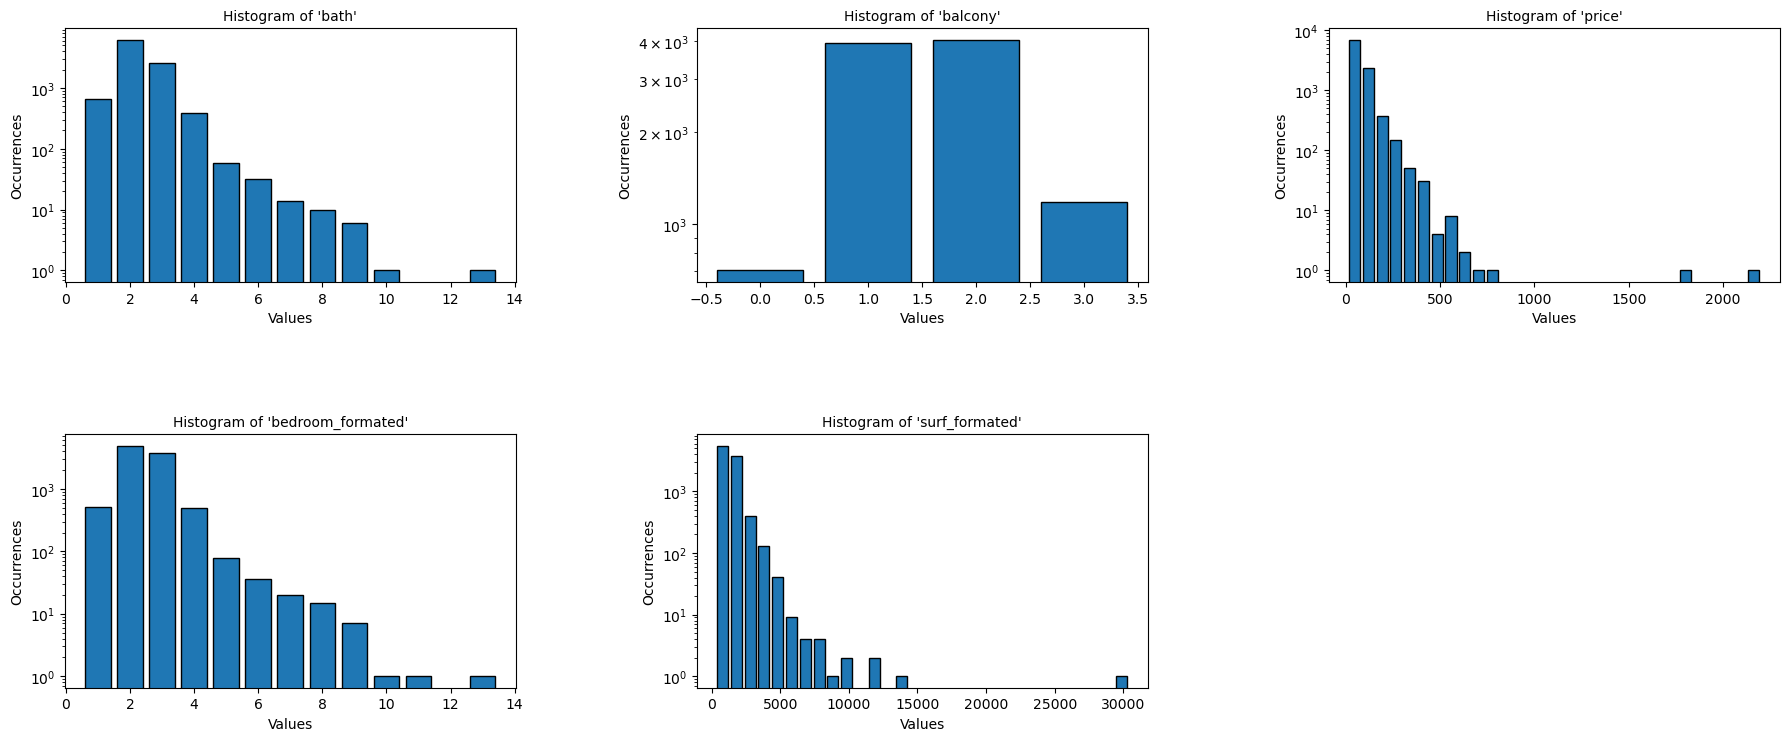

In [40]:
discrete_columns = ['bath', 'balcony', 'bedroom_formated']
continuous_columns = ['price', 'surf_formated']

k = 0
plt.figure(figsize=(18, 12))

for col_name in list_columns_to_visualize:
    k += 1
    plt.subplot(3, 3, k)
    if col_name in discrete_columns:
        min_value = df7[col_name].min()
        max_value = df7[col_name].max()
        bins = np.arange(min_value - 0.5, max_value + 1.5, 1)  
    else:
        bins = 30  # Arbitrarily chosen
    
    plt.hist(df7[col_name], rwidth=0.8, bins=bins, edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Occurrences')
    plt.yscale('log')
    plt.title(f"Histogram of '{col_name}'", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.6, wspace=0.4)
plt.show()


<h1 style="color:blue; font-weight:bold;"> Model Conception </h1>

In [41]:
X = df7.drop('price', axis = 'columns')
y = df7.price

In [42]:
X

,bath,balcony,bedroom_formated,surf_formated,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,loc_formated_8th Phase JP Nagar,loc_formated_Akshaya Nagar,loc_formated_Banashankari,...,loc_formated_Sarjapur,loc_formated_Sarjapur Road,loc_formated_TC Palaya,loc_formated_Thanisandra,loc_formated_Thigalarapalya,loc_formated_Uttarahalli,loc_formated_Varthur,loc_formated_Whitefield,loc_formated_Yelahanka,loc_formated_Yeshwanthpur
0,2.0,1.0,2,1056.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.0,3,1440.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,3.0,1.0,3,1521.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,1.0,2,1200.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2.0,1.0,2,1170.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13314,3.0,3.0,3,1715.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13315,4.0,0.0,5,3453.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
13317,2.0,1.0,2,1141.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13318,4.0,1.0,4,4689.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# X[['bath','balcony','bedroom_formated','surf_formated']] = ss.fit_transform(X[['bath','balcony','bedroom_formated','surf_formated']])

# from sklearn.decomposition import PCA
# pca = PCA(0.8) # 95 % des features utiles sont extraites
# X_pca = pca.fit_transform(X)

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [45]:
parameters = {
    'svr' : {
    'model' : SVR(),
    'params' : {
        'kernel':['rbf', 'linear'],
        'gamma':['auto','scale']
        }
    },
    'rf' : {
    'model' : RandomForestRegressor(),
    'params' : {
        'n_estimators': [50, 100], 
        'criterion' :['squared_error','absolute_error'],
        'max_depth': [None, 10, 100], 
        'max_features': ['auto', 'sqrt']
        }
    },
    'lr' : {
    'model' : LinearRegression(),
    'params' : {
    'fit_intercept': [True, False]
        }
    },
    'lasso' : {
    'model' : Lasso(max_iter=1000),
    'params' : {
        'alpha': [0.001, 0.01, 0.1, 1], 
        'fit_intercept': [True, False]
        }
    }
}


In [46]:
# %%time
# for model_name, model_params in parameters.items():
#     if model_name == 'svr':
#         nb_max_iter = 4
#     elif model_name == 'rf':
#         nb_max_iter = 12
#     elif model_name == 'lr':
#         nb_max_iter = 2
#     elif model_name == 'lasso':
#         nb_max_iter = 8
#     rscv = RandomizedSearchCV(model_params['model'], model_params['params'], cv = 4, verbose = 2, n_iter=nb_max_iter, n_jobs = -1)
#     rscv.fit(X, y)
#     print(f'Les meilleures performances de {model_name} sont de {rscv.best_score_}, atteintes avec les paramètres {rscv.best_params_}. \n')

In [47]:
# %%time
# for model_name, model_params in parameters.items():
#     gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 3, n_jobs = -1)
#     gscv.fit(X, y)
#     print(f'Les meilleures performances de {model_name} sont de {gscv.best_score_}, atteintes avec les paramètres {gscv.best_params_}. \n')

In [58]:
# scores = []
# for k in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#     lr = LinearRegression()
#     lr.fit(X_train, y_train)
#     scores.append(lr.score(X_test, y_test))
#     print('===', lr.score(X_test, y_test), '===')
# np.mean(scores)

=== 0.7527616321093138 ===
=== 0.8223716597747301 ===
=== 0.7171393817563456 ===
=== 0.7833781270213118 ===
=== 0.6964530711532677 ===
=== 0.7241263419627204 ===
=== 0.7808578653201336 ===
=== 0.7585553189535348 ===
=== 0.7968903607920199 ===
=== 0.7805023820648243 ===
=== 0.7395452918937617 ===
=== 0.7048037957300741 ===
=== 0.7374668011177854 ===
=== 0.7468194943695803 ===
=== 0.7932461437946141 ===
=== 0.6784997073532422 ===
=== 0.8384317546781381 ===
=== 0.6743040513095058 ===
=== 0.7572682850001786 ===
=== 0.760248410859582 ===
=== 0.7461846740123028 ===
=== 0.7900708623077644 ===
=== 0.7807656314671624 ===
=== 0.6725949959573418 ===
=== 0.7004178346588461 ===
=== 0.7549864753332567 ===
=== 0.7713306580352515 ===
=== 0.7461054714010442 ===
=== 0.776481711181451 ===
=== 0.7698251851777395 ===
=== 0.8343835294023142 ===
=== 0.7747664372930686 ===
=== 0.8425662755425355 ===
=== 0.8036238405119448 ===
=== 0.7614923520844309 ===
=== 0.7085188845217893 ===
=== 0.7982665742874984 ===
===

0.7545411249975286

In [60]:
from sklearn.ensemble import BaggingRegressor
bag_model = BaggingRegressor(
    estimator = LinearRegression(), # Modèle choisi arbitrairement
    n_estimators = 1000,
    max_samples = 0.8,
    oob_score = True,
    random_state = 11)
bag_model.fit(X_train, y_train)
bag_model.score(X_test, y_test)
#print(bag_model.oob_score_)

0.8490939067814369